In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style(theme='chesterish')

from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model

import pickle


In [58]:
plt.rcParams["figure.figsize"] = [16,9]

In [59]:
def SMAPE (forecast, actual):
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

In [60]:
def Fuller(TimeSeries):
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [61]:
def xboost(x_train, y_train, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_csv('/content/drive/MyDrive/Model_hackathon/train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [65]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

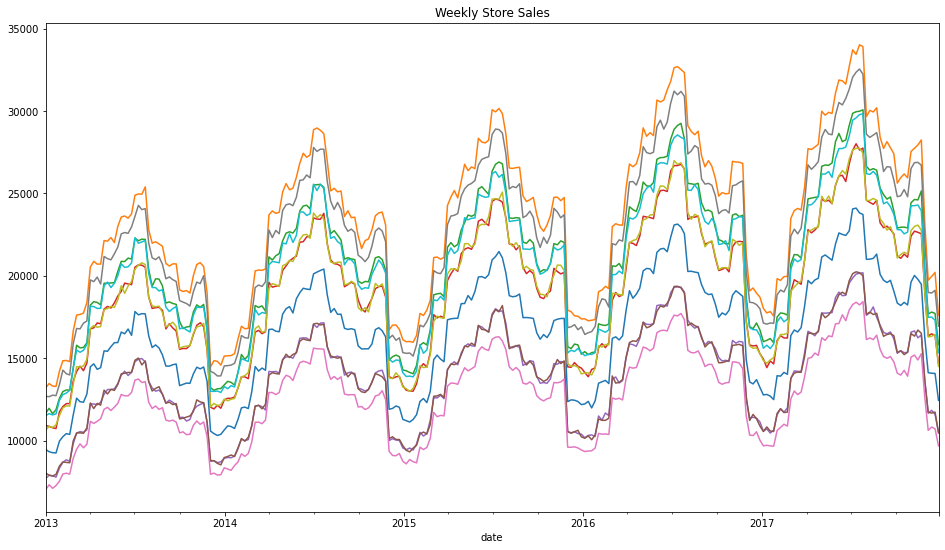

In [66]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

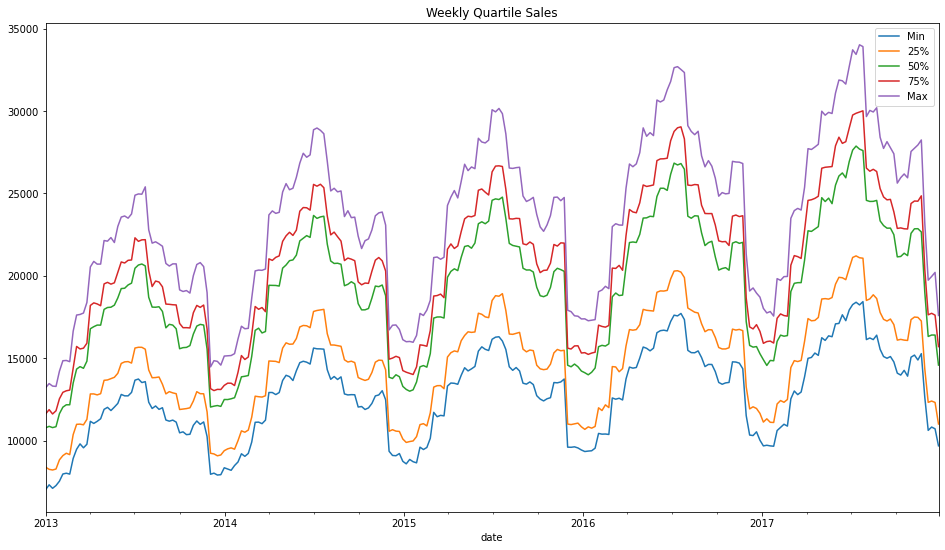

In [67]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

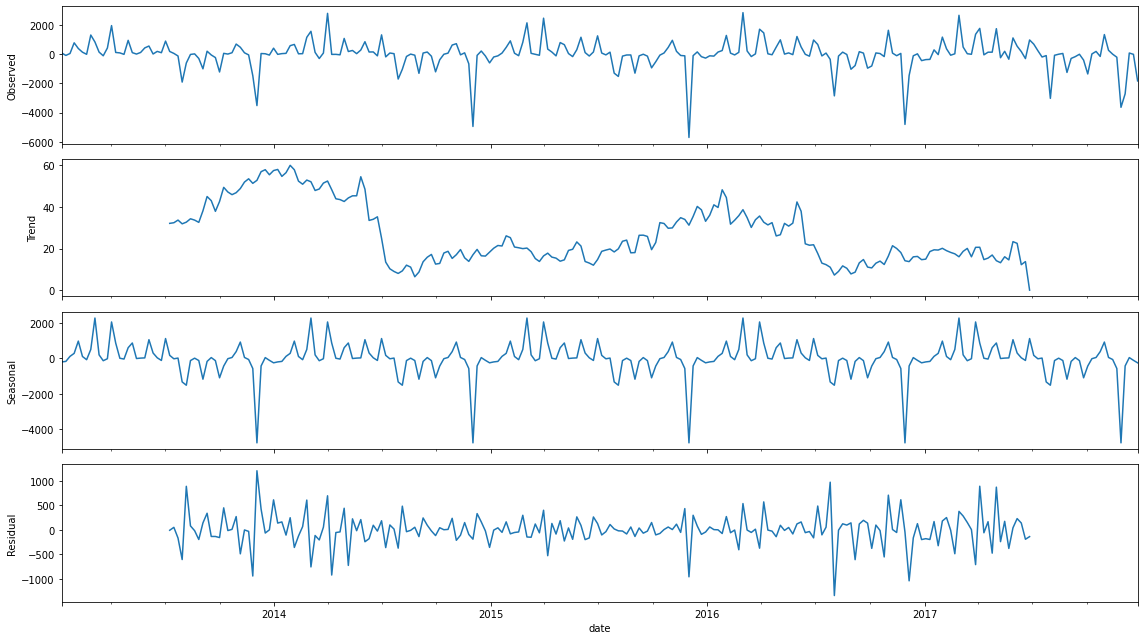

In [68]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [69]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [70]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail

<bound method NDFrame.tail of            sales                          ...                              
item          1     2     3     4     5   ...    46    47    48    49    50
date                                      ...                              
2013-01-01   894  2320  1444   834   664  ...  2313   861  2095  1206  2550
2013-01-08   863  2348  1466   839   714  ...  2408   874  2008  1183  2665
2013-01-15   867  2411  1444   854   685  ...  2299   886  1988  1101  2645
2013-01-22   816  2331  1411   836   759  ...  2305   895  1946  1133  2601
2013-01-29   969  2470  1528   939   760  ...  2496   943  2144  1204  2735
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
2017-11-28  1490  4042  2527  1509  1301  ...  4028  1591  3580  1991  4503
2017-12-05  1311  3551  2182  1296  1179  ...  3510  1283  3101  1669  3829
2017-12-12  1308  3498  2251  1277  1125  ...  3483  1279  3051  1701  3856
2017-12-19  1262  3450  2181  1306  1085  ...  3524  1361 

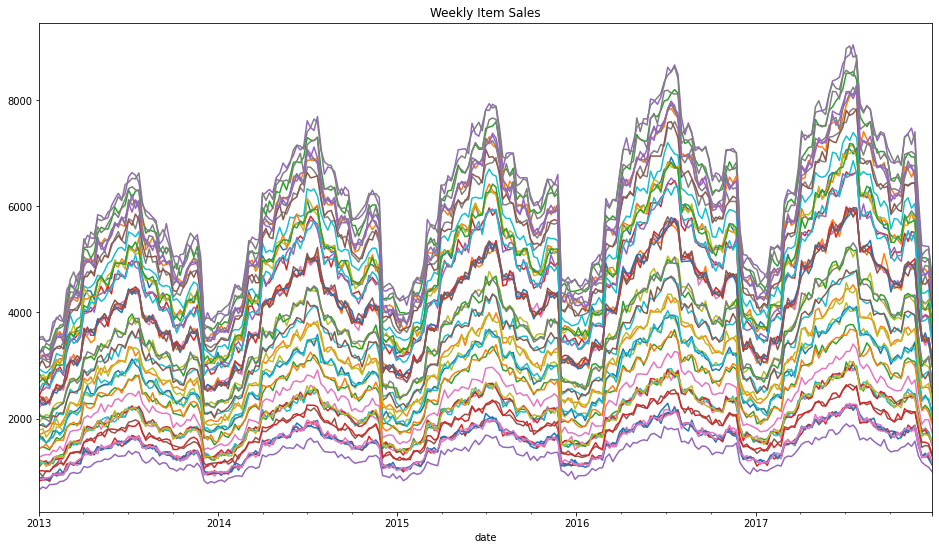

In [71]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

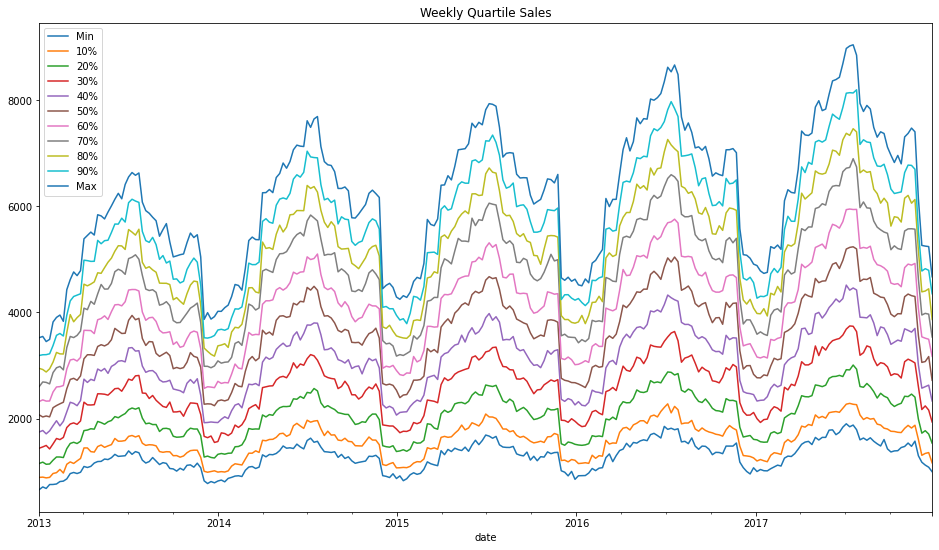

In [72]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

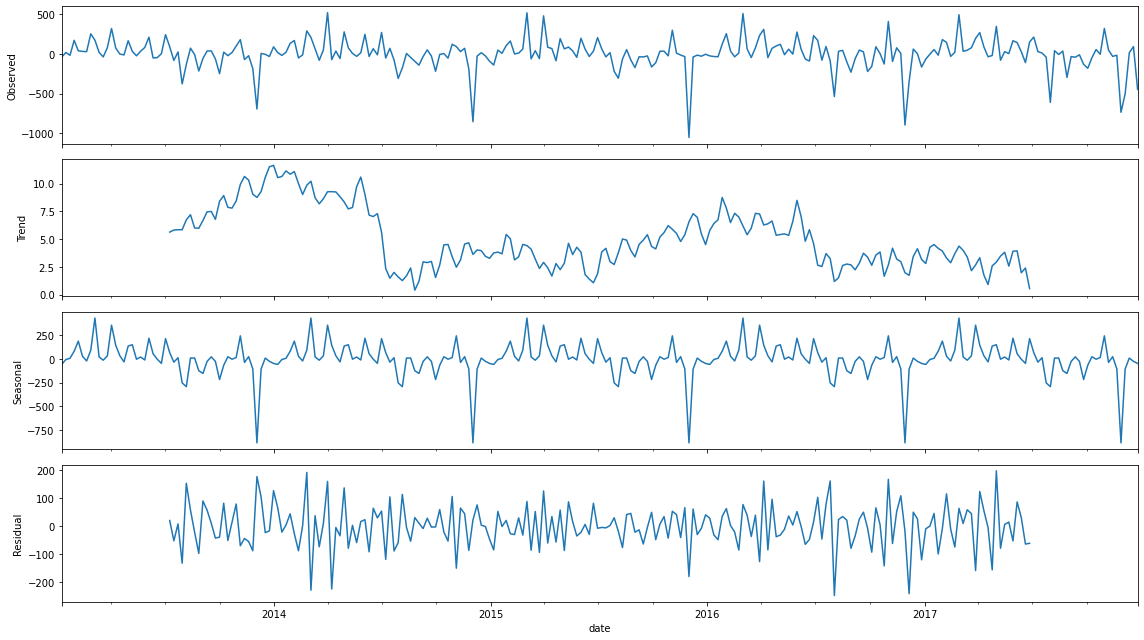

In [73]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()

In [74]:
Fuller(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -13.061788
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


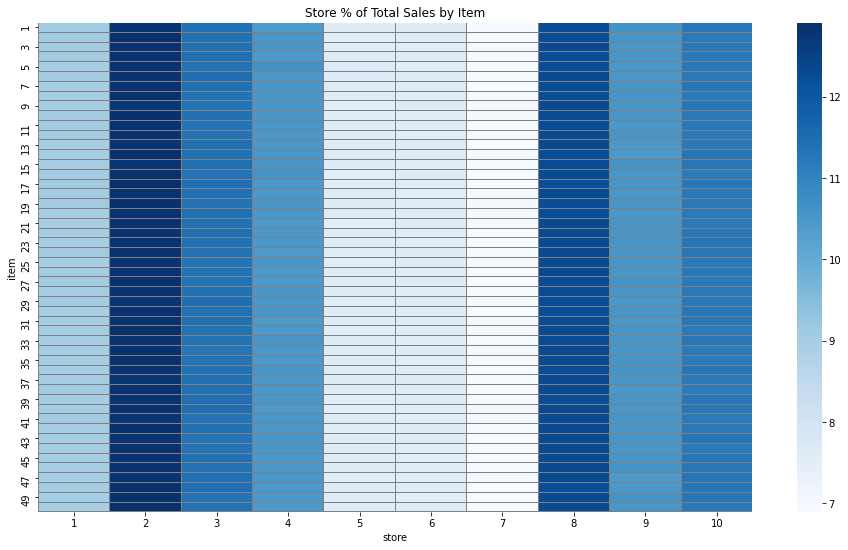

In [75]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

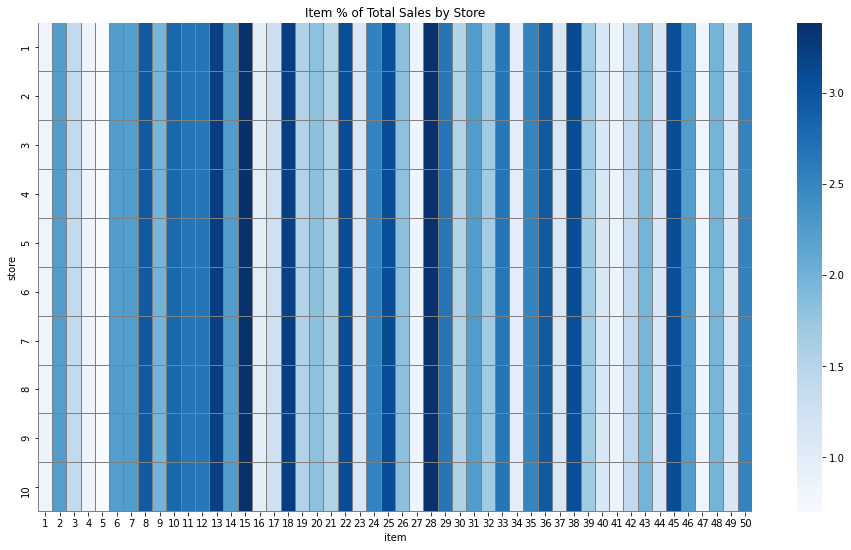

In [76]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

In [77]:
df['Day'] = df.index.day_name()
df.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


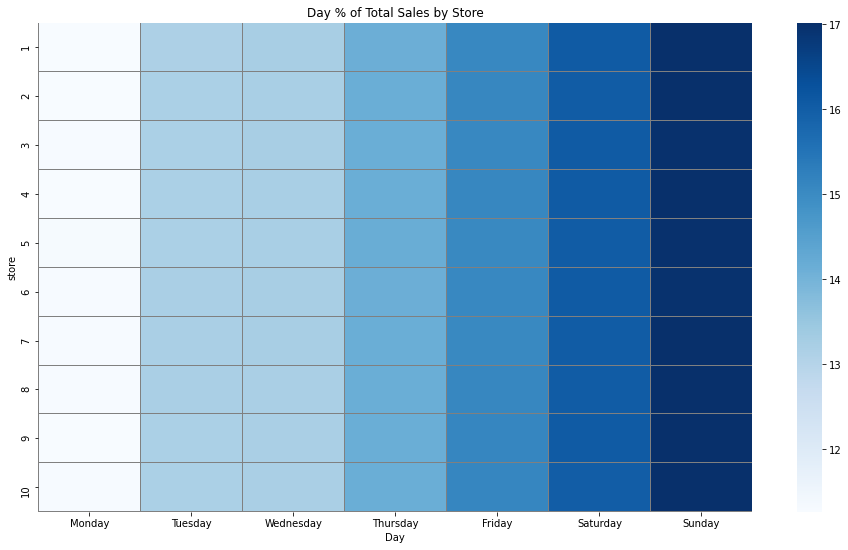

In [78]:
dow_store = df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

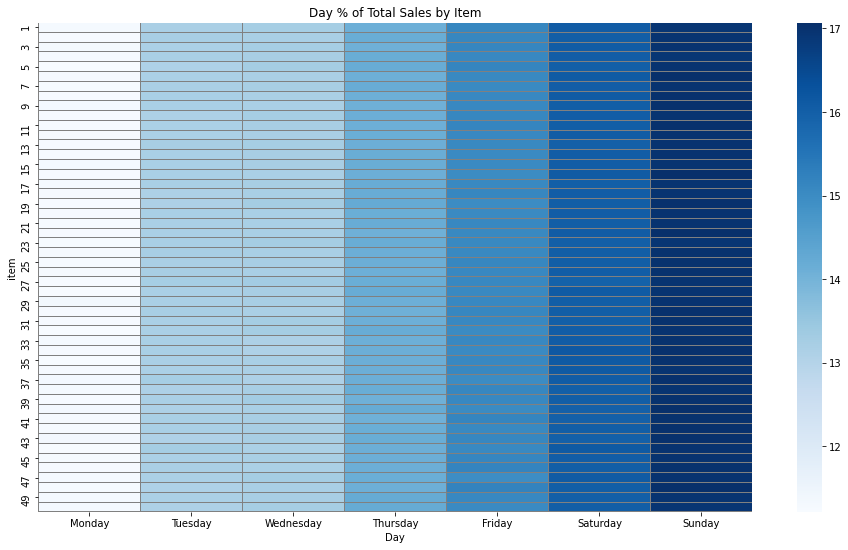

In [79]:
dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

In [80]:
dow = pd.DataFrame(df.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

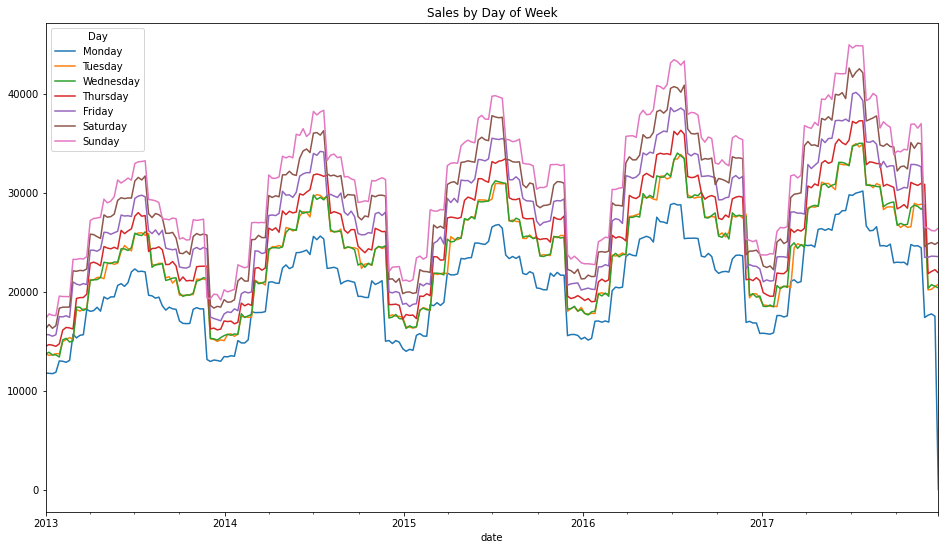

In [81]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

In [82]:
train = item_WK_qtr[:-13]
test = df.loc[df.index >= pd.to_datetime('October 3, 2017')] # last 13 weeks of data

In [83]:
store_pct = store_item.transpose()
store_pct

item,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9.085564,9.073791,9.062798,9.066774,9.049011,9.069617,9.018065,9.028203,9.049435,9.061402,9.075692,9.080764,9.032548,9.057134,9.051462,9.094305,9.083863,9.059015,9.088442,9.026544,8.972955,9.040927,9.034747,9.084765,9.014657,9.074796,9.093506,9.053893,9.061704,9.003685,9.038937,9.057822,9.021692,9.043804,9.041556,8.997915,9.031404,9.108635,9.045552,9.040731,9.091271,9.023547,9.015145,9.046201,9.024192,9.011790,9.005155,9.063957,9.020410,9.007414
2,12.816904,12.858324,12.824640,12.828092,12.822540,12.810300,12.823723,12.877231,12.741440,12.850031,12.821511,12.831273,12.797370,12.842092,12.788580,12.843024,12.901545,12.828974,12.840823,12.833188,12.837311,12.795899,12.823120,12.837165,12.818275,12.824993,12.852310,12.817058,12.780120,12.848074,12.836125,12.904258,12.839331,12.858161,12.866311,12.822527,12.768737,12.822496,12.798526,12.844930,12.757648,12.910997,12.825060,12.853127,12.828966,12.827383,12.810710,12.857803,12.855471,12.844459
3,11.405039,11.405115,11.399713,11.411098,11.361155,11.453447,11.386753,11.373289,11.381009,11.387498,11.383218,11.356912,11.411120,11.390431,11.407752,11.359076,11.442092,11.401958,11.362588,11.415897,11.398552,11.409069,11.396709,11.379257,11.382280,11.374961,11.379238,11.395309,11.445439,11.391154,11.420420,11.377313,11.375526,11.304117,11.340603,11.392928,11.429497,11.409548,11.433264,11.476819,11.357555,11.392619,11.345828,11.356511,11.398149,11.382714,11.416667,11.430911,11.337725,11.377637
4,10.435394,10.536256,10.520157,10.488994,10.635385,10.472900,10.528670,10.502894,10.516433,10.521691,10.537571,10.498028,10.508560,10.524007,10.525170,10.592768,10.471945,10.501431,10.515517,10.527511,10.490498,10.513269,10.491253,10.465557,10.537393,10.473907,10.481636,10.531541,10.520673,10.533376,10.454361,10.473200,10.548795,10.491664,10.481540,10.519015,10.505224,10.503288,10.520634,10.446476,10.529945,10.504758,10.531103,10.528659,10.509172,10.474110,10.504977,10.469840,10.513140,10.461351
5,7.615152,7.595244,7.596620,7.622161,7.672941,7.617378,7.608884,7.610874,7.557394,7.580473,7.605952,7.618200,7.637399,7.653535,7.609544,7.557420,7.597355,7.603667,7.608578,7.649592,7.562993,7.625661,7.628150,7.592861,7.584974,7.630741,7.602551,7.621737,7.580630,7.620487,7.621925,7.561633,7.641812,7.634673,7.626373,7.603082,7.618042,7.618834,7.572840,7.558969,7.649611,7.558458,7.634991,7.624657,7.622733,7.628759,7.589458,7.649330,7.626250,7.637765
6,7.605435,7.603005,7.589895,7.611960,7.567640,7.606987,7.619737,7.587459,7.678561,7.588026,7.613342,7.592797,7.628955,7.602953,7.573337,7.646218,7.594699,7.561558,7.553888,7.617782,7.645445,7.581238,7.593195,7.647588,7.605268,7.589131,7.623414,7.562536,7.649067,7.602430,7.610438,7.603844,7.572137,7.638290,7.594248,7.641545,7.666895,7.615093,7.604164,7.583122,7.548057,7.602791,7.609901,7.593175,7.587462,7.595511,7.593689,7.604753,7.561284,7.667690
7,6.896388,6.951524,6.967704,6.977734,6.936133,6.957439,6.955239,6.981670,6.986196,6.985992,6.947422,6.971894,6.943787,6.990652,6.945196,6.920039,6.917671,6.970672,6.982977,6.997940,6.997243,6.959253,6.909617,6.926346,6.989861,6.930151,6.899669,6.953019,6.969101,6.961336,6.993916,6.973043,6.948605,6.986924,6.998097,6.952624,6.921001,6.932253,6.975444,6.972743,7.031828,6.933015,6.906426,6.954962,6.937566,6.962599,7.034927,6.937165,6.956239,6.955393
8,12.275527,12.233490,12.301689,12.243629,12.216389,12.299760,12.255129,12.275640,12.296844,12.265646,12.274151,12.299003,12.313095,12.201887,12.273849,12.281634,12.211238,12.319121,12.252813,12.216112,12.315707,12.287181,12.284781,12.295777,12.300062,12.304177,12.265168,12.268050,12.242614,12.202228,12.273578,12.278937,12.269098,12.329365,12.285890,12.250702,12.313526,12.288330,12.247430,12.306448,12.287964,12.304810,12.278209,12.311782,12.278019,12.279176,12.339060,12.216875,12

In [84]:
fitted_items_WK = []
qtr_list = [0] *11

for column in items:
    for c in range(11):
        qtr_list[c] = [fdt.fastdtw(items[column],item_WK_qtr.iloc[:,c], dist= euclidean)[0], c]
    qtr_list.sort()
    fitted_items_WK.append([column[1], qtr_list[0][1], qtr_list[0][0]])

In [85]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2013')

In [86]:
itm_quart = pd.DataFrame(fitted_items_WK, columns=['item','item_quart','item_metric'])

def add_feat(df, train_end_str):
    """Adds Features to DataFrame and Takes Averages for Dates Before train_end_str"""
    
    dataf = df
    
    dataf['Weekday'] = dataf.index.dayofweek
    dataf['Is_Mon'] = (dataf.index.dayofweek == 0) *1
    dataf['Is_Tue'] = (dataf.index.dayofweek == 1) *1
    dataf['Is_Wed'] = (dataf.index.dayofweek == 2) *1
    dataf['Is_Thu'] = (dataf.index.dayofweek == 3) *1
    dataf['Is_Fri'] = (dataf.index.dayofweek == 4) *1
    dataf['Is_Sat'] = (dataf.index.dayofweek == 5) *1
    dataf['Is_Sun'] = (dataf.index.dayofweek == 6) *1
    dataf['Is_wknd'] = dataf.index.dayofweek // 4 # Fri-Sun are 4-6, Monday is 0 so this is valid
    dataf['Day_Num'] = ((dataf.index - start_date)/ ns_per_day).astype(int)
    
    dataf['Month'] = dataf.index.month
    dataf['Day_of_Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 364
    dataf['Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) // 364 -1
    dataf['Day_of_Quarter'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 91
    dataf['Quarter'] = (((dataf.index - start_date)/ ns_per_day).astype(int) // 91) % 4
    dataf.reset_index(inplace=True)
    
    # Add item quartile as feature
    dataf = dataf.merge(itm_quart, on='item').drop('item_metric', axis=1)

    # Add prior year sales as additional feature
    prior_year_sales = dataf[['date','sales','store','item']]
    prior_year_sales['date'] += pd.Timedelta('364 days')
    prior_year_sales.columns =['date','lag_12mo','store','item']

    dataf = dataf.merge(prior_year_sales, on=['date','store','item'])
    
    # Add average by item by store by day of year as additional feature
    avg = dataf.loc[df['date'] < pd.to_datetime(train_end_str), ['Day_of_Year','sales','store','item']].groupby(by=['Day_of_Year','store','item']).mean().reset_index()
    avg.columns =['Day_of_Year','store','item','DoY_Mean']
    
    dataf = dataf.merge(avg, on=['Day_of_Year','store','item'])
    
    # Add average by day of week by quarter by item by store as additional feature
    avg = dataf.loc[df['date'] < pd.to_datetime(train_end_str), ['Quarter','Weekday','sales','store','item']].groupby(by=['Quarter','Weekday','store','item']).mean().reset_index()
    avg.columns =['Quarter','Weekday','store','item','DoW_Mean']
    
    dataf = dataf.merge(avg, on=['Quarter','Weekday','store','item'])
    
    # Id's start at 0 instead of 1
    dataf['store'] -=1
    dataf['item'] -=1
    
    # Remove first year of data as there is no prior year sales for them, then sort to match competition id's
    dataf = dataf[dataf['Year'] >=0].drop('Year', axis=1).sort_values(['item','store','date'])
    
    return dataf

In [87]:
df_test = add_feat(df, 'October 3, 2017') # Takes average of training data

df_test.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,store,item,sales,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
730843,2017-12-22,9,49,75,Friday,4,0,0,0,0,1,0,0,1,1816,12,360,87,3,7,64,63.0,74.884615
730895,2017-12-23,9,49,70,Saturday,5,0,0,0,0,0,1,0,1,1817,12,361,88,3,7,65,69.0,81.980769
730947,2017-12-24,9,49,76,Sunday,6,0,0,0,0,0,0,1,1,1818,12,362,89,3,7,64,66.0,85.634615
730999,2017-12-25,9,49,51,Monday,0,1,0,0,0,0,0,0,0,1819,12,363,90,3,7,61,47.0,59.230769
729542,2017-12-26,9,49,41,Tuesday,1,0,1,0,0,0,0,0,0,1820,12,0,0,0,7,60,47.4,53.037736
729595,2017-12-27,9,49,63,Wednesday,2,0,0,1,0,0,0,0,0,1821,12,1,1,0,7,43,46.8,54.924528
729648,2017-12-28,9,49,59,Thursday,3,0,0,0,1,0,0,0,0,1822,12,2,2,0,7,68,54.6,59.943396
729701,2017-12-29,9,49,74,Friday,4,0,0,0,0,1,0,0,1,1823,12,3,3,0,7,63,60.0,64.075472
729754,2017-12-30,9,49,62,Saturday,5,0,0,0,0,0,1,0,1,1824,12,4,4,0,7,64,59.2,67.603774
729807,2017-12-31,9,49,82,Sunday,6,0,0,0,0,0,0,1,1,1825,12,5,5,0,7,69,69.6,70.811321


In [88]:
df_test.head(10)

,date,store,item,sales,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,2013-12-31,0,0,15,Tuesday,1,0,1,0,0,0,0,0,0,364,12,0,0,0,1,13,12.80,13.735849
53,2014-01-01,0,0,9,Wednesday,2,0,0,1,0,0,0,0,0,365,1,1,1,0,1,11,13.20,16.132075
106,2014-01-02,0,0,14,Thursday,3,0,0,0,1,0,0,0,0,366,1,2,2,0,1,14,16.60,15.943396
159,2014-01-03,0,0,11,Friday,4,0,0,0,0,1,0,0,1,367,1,3,3,0,1,13,18.00,17.075472
212,2014-01-04,0,0,20,Saturday,5,0,0,0,0,0,1,0,1,368,1,4,4,0,1,10,18.00,17.283019
265,2014-01-05,0,0,17,Sunday,6,0,0,0,0,0,0,1,1,369,1,5,5,0,1,12,17.00,19.603774
318,2014-01-06,0,0,14,Monday,0,1,0,0,0,0,0,0,0,370,1,6,6,0,1,10,13.75,12.538462
5,2014-01-07,0,0,11,Tuesday,1,0,1,0,0,0,0,0,0,371,1,7,7,0,1,9,10.50,13.735849
58,2014-01-08,0,0,12,Wednesday,2,0,0,1,0,0,0,0,0,372,1,8,8,0,1,12,14.25,16.132075
111,2014-01-09,0,0,17,Thursday,3,0,0,0,1,0,0,0,0,373,1,9,9,0,1,9,15.25,15.943396


In [89]:
x_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017')].drop(['sales','date','Day', 'Weekday'], axis=1)
y_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017'), 'sales']

x_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017')].drop(['sales','date','Day', 'Weekday'], axis=1).reset_index(drop=True)
y_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].reset_index(drop=True)

In [90]:
feat_cols =[]

for col in x_train.drop(['lag_12mo','DoW_Mean','DoY_Mean'], axis=1).columns:
    feat_cols.append(tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(col, max(df_test[col])+1),1))
    
feat_cols.append(tf.feature_column.numeric_column(key='lag_12mo'))
feat_cols.append(tf.feature_column.numeric_column(key='DoY_Mean'))
feat_cols.append(tf.feature_column.numeric_column(key='DoW_Mean'))

In [91]:
input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x= x_train, y= y_train, batch_size= 180, num_epochs= 80,
                                                 shuffle= False)

In [92]:
regressor = tf.estimator.DNNRegressor(hidden_units= [20, 10, 20], feature_columns= feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpi_nxfh59', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [93]:
regressor.train(input_fn= input_func)

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:global_step/sec: 208.041
INFO:tensorflow:loss = 78.21196, step = 59400 (0.487 sec)
INFO:tensorflow:global_step/sec: 203.988
INFO:tensorflow:loss = 28.553375, step = 59500 (0.484 sec)
INFO:tensorflow:global_step/sec: 199.43
INFO:tensorflow:loss = 104.535614, step = 59600 (0.505 sec)
INFO:tensorflow:global_step/sec: 197.87
INFO:tensorflow:loss = 77.00223, step = 59700 (0.507 sec)
INFO:tensorflow:global_step/sec: 210.254
INFO:tensorflow:loss = 139.73259, step = 59800 (0.476 sec)
INFO:tensorflow:global_step/sec: 201.302
INFO:tensorflow:loss = 41.638756, step = 59900 (0.491 sec)
INFO:tensorflow:global_step/sec: 206.092
INFO:tensorflow:loss = 22.14835, step = 60000 (0.487 sec)
INFO:tensorflow:global_step/sec: 205.729
INFO:tensorflow:loss = 84.00404, step = 60100 (0.486 sec)
INFO:tensorflow:global_step/sec: 207.265
INFO:tensorflow:loss = 28.895931, step = 60200 (0.487 sec)
INFO:tensorflow:global_step/sec: 206.603
INFO:tensorfl

In [94]:
pred_fn =tf.compat.v1.estimator.inputs.pandas_input_fn(x= x_test, batch_size =len(x_test), shuffle=False)

In [95]:
x_test.head()

,store,item,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,1,0,1,0,0,0,0,0,0,0,370,1,6,6,0,1,12,17.25,16.625000
1,1,0,1,0,0,0,0,0,0,0,377,1,13,13,0,1,14,16.75,16.625000
2,1,0,0,0,0,0,0,0,1,1,383,1,19,19,0,1,24,25.00,25.871795
3,1,0,1,0,0,0,0,0,0,0,384,1,20,20,0,1,13,13.00,16.625000
4,1,0,0,0,0,0,0,0,1,1,390,1,26,26,0,1,12,21.00,25.871795


In [96]:
predictions = list(regressor.predict(input_fn= pred_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi_nxfh59/model.ckpt-308889
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [97]:
final_pred = []

for pred in predictions:
    final_pred.append(pred['predictions'][0])

final_pred = pd.DataFrame(final_pred)

In [98]:
SMAPE(final_pred.iloc[:,0], y_test)

SMAPE Error Score: 11.85 %


In [99]:
preds = xboost(x_train, y_train, x_test)

In [100]:
SMAPE(preds, y_test)

SMAPE Error Score: 10.14 %


In [108]:
df1 = pd.read_csv('/content/drive/MyDrive/Model_hackathon/train.csv', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/Model_hackathon/test.csv', index_col=1)

df2.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [109]:
df = pd.concat([df1,df2])
df.index = pd.to_datetime(df.index)

df.tail()

,store,item,sales,id
date,,,,
2018-03-27,10,50,NaN,44995.0
2018-03-28,10,50,NaN,44996.0
2018-03-29,10,50,NaN,44997.0
2018-03-30,10,50,NaN,44998.0
2018-03-31,10,50,NaN,44999.0


In [110]:
df = add_feat(df, 'April 1, 2018') # Takes average of non-competition data

df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,store,item,sales,id,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,2013-12-31,0,0,15.0,NaN,1,0,1,0,0,0,0,0,0,364,12,0,0,0,1,13.0,12.80,13.735849
65,2014-01-01,0,0,9.0,NaN,2,0,0,1,0,0,0,0,0,365,1,1,1,0,1,11.0,13.20,16.132075
130,2014-01-02,0,0,14.0,NaN,3,0,0,0,1,0,0,0,0,366,1,2,2,0,1,14.0,16.60,15.943396
195,2014-01-03,0,0,11.0,NaN,4,0,0,0,0,1,0,0,1,367,1,3,3,0,1,13.0,18.00,17.075472
260,2014-01-04,0,0,20.0,NaN,5,0,0,0,0,0,1,0,1,368,1,4,4,0,1,10.0,18.00,17.283019
325,2014-01-05,0,0,17.0,NaN,6,0,0,0,0,0,0,1,1,369,1,5,5,0,1,12.0,17.00,19.603774
390,2014-01-06,0,0,14.0,NaN,0,1,0,0,0,0,0,0,0,370,1,6,6,0,1,10.0,13.75,12.538462
5,2014-01-07,0,0,11.0,NaN,1,0,1,0,0,0,0,0,0,371,1,7,7,0,1,9.0,10.50,13.735849
70,2014-01-08,0,0,12.0,NaN,2,0,0,1,0,0,0,0,0,372,1,8,8,0,1,12.0,14.25,16.132075
135,2014-01-09,0,0,17.0,NaN,3,0,0,0,1,0,0,0,0,373,1,9,9,0,1,9.0,15.25,15.943396


In [111]:
df.tail(10)

,date,store,item,sales,id,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
774642,2018-03-22,9,49,NaN,44990.0,3,0,0,0,1,0,0,0,0,1906,3,86,86,0,7,67.0,71.25,59.943396
774707,2018-03-23,9,49,NaN,44991.0,4,0,0,0,0,1,0,0,1,1907,3,87,87,0,7,73.0,78.00,64.075472
774772,2018-03-24,9,49,NaN,44992.0,5,0,0,0,0,0,1,0,1,1908,3,88,88,0,7,79.0,72.00,67.603774
774837,2018-03-25,9,49,NaN,44993.0,6,0,0,0,0,0,0,1,1,1909,3,89,89,0,7,81.0,77.75,70.811321
774902,2018-03-26,9,49,NaN,44994.0,0,1,0,0,0,0,0,0,0,1910,3,90,90,0,7,66.0,60.25,47.634615
774907,2018-03-27,9,49,NaN,44995.0,1,0,1,0,0,0,0,0,0,1911,3,91,0,1,7,60.0,63.00,79.269231
774960,2018-03-28,9,49,NaN,44996.0,2,0,0,1,0,0,0,0,0,1912,3,92,1,1,7,73.0,66.50,80.634615
775013,2018-03-29,9,49,NaN,44997.0,3,0,0,0,1,0,0,0,0,1913,3,93,2,1,7,68.0,74.50,87.269231
775066,2018-03-30,9,49,NaN,44998.0,4,0,0,0,0,1,0,0,1,1914,3,94,3,1,7,69.0,73.75,90.500000
775119,2018-03-31,9,49,NaN,44999.0,5,0,0,0,0,0,1,0,1,1915,3,95,4,1,7,101.0,85.50,98.480769


In [112]:
x_train = df[pd.isnull(df['id'])].drop(['id','sales','date'], axis=1)
y_train = df[pd.isnull(df['id'])]['sales']

x_test = df[pd.notnull(df['id'])].drop(['id','sales','date'], axis=1)

In [113]:
preds = pd.DataFrame(xboost(x_train, y_train, x_test)).reset_index()
preds.columns =['id','sales']

In [114]:
preds

,id,sales
0,0,16.218586
1,1,12.942932
2,2,16.275352
3,3,18.729736
4,4,17.496466
...,...,...
44995,44995,70.797218
44996,44996,71.607208
44997,44997,85.300545
44998,44998,85.233192


In [ ]:
"""preds.to_csv('sample.csv', index=False)"""

In [121]:
pickle.dump(preds,open('model.pkl','wb'))
model=pickle.load(open('model.pkl','rb'))

In [123]:
from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>